
# Setup and Initialization

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import requests
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Configure display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set up API access
BASE_URL = 'https://api.themoviedb.org/3/movie/'

# Define movie IDs

In [2]:
movie_ids = [0, 299534, 19995, 140607, 299536, 597, 135397, 420818, 24428, 
             168259, 99861, 284054, 12445, 181808, 330457, 351286, 109445, 
             321612, 260513]


# Function to fetch Movie Data from API 

In [3]:
def fetch_movie_data(movie_id, api_key):
    """Fetch movie data from TMDB API for a given movie ID"""
    try:
        url = f"{BASE_URL}{movie_id}?api_key={api_key}&append_to_response=credits"
        response = requests.get(url)
        response.raise_for_status()  # Raise error for bad status codes
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for movie ID {movie_id}: {e}")
        return None


# Fetch All Movie Data

In [4]:
# Fetch data for all movies
all_movies_data = []
for movie_id in movie_ids:
    movie_data = fetch_movie_data(movie_id, API_KEY)
    if movie_data:
        all_movies_data.append(movie_data)
    else:
        print(f"Skipping movie ID {movie_id} due to fetch error")

# Create DataFrame
movies_df = pd.json_normalize(all_movies_data)

Error fetching data for movie ID 0: 404 Client Error: Not Found for url: https://api.themoviedb.org/3/movie/0?api_key=f1ed7ada452dffa6f7d5fb68673be2ee&append_to_response=credits
Skipping movie ID 0 due to fetch error


In [6]:
# Save to JSON inside the folder
file_path = r"C:\Datasets\M_Data\movies_data.json"
movies_df.to_json(file_path, indent=2)  # Adds readability

print(f"File saved to: {file_path}")

File saved to: C:\Datasets\M_Data\movies_data.json



# Data Cleaning and Preprocessing

In [5]:

# Drop Irrelevant Columns
columns_to_drop = ['adult', 'imdb_id', 'original_title', 'video', 'homepage']
movies_df = movies_df.drop(columns=columns_to_drop, errors='ignore')

In [ ]:
# Process JSON-like Columns
def extract_json_field(row, field_name, subfield='name'):
    """Extract values from JSON-like columns"""
    field_value = row[field_name]
    
    # Handle array-like input (convert to first element if array)
    if isinstance(field_value, (np.ndarray, list, pd.Series)):
        if len(field_value) == 0:
            return np.nan
        field_value = field_value[0]
    
    # Handle NaN/None cases
    if pd.isna(field_value):
        return np.nan
    
    # Handle empty string case
    if isinstance(field_value, str) and not field_value.strip():
        return np.nan
    
    # Handle empty dictionary case
    if isinstance(field_value, dict) and not field_value:
        return np.nan
    
    try:
        # Parse JSON if it's a string, otherwise use as-is
        data = json.loads(field_value) if isinstance(field_value, str) else field_value
        
        if isinstance(data, list):
            return "|".join([str(item.get(subfield, '')) for item in data if isinstance(item, dict)])
        elif isinstance(data, dict):
            return data.get(subfield, np.nan)
        return np.nan
    except (json.JSONDecodeError, TypeError, AttributeError):
        return np.nan

# Apply to JSON columns
json_columns = {
    'belongs_to_collection': 'name',
    'genres': 'name',
    'production_countries': 'name',
    'production_companies': 'name',
    'spoken_languages': 'name'
}

for col, subfield in json_columns.items():
    movies_df[col] = movies_df.apply(lambda x: extract_json_field(x, col, subfield), axis=1)

In [7]:
# Handle Missing and Incorrect Data
# Convert data types
movies_df['budget'] = pd.to_numeric(movies_df['budget'], errors='coerce')
movies_df['revenue'] = pd.to_numeric(movies_df['revenue'], errors='coerce')
movies_df['popularity'] = pd.to_numeric(movies_df['popularity'], errors='coerce')
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'], errors='coerce')

# Convert budget and revenue to million USD
movies_df['budget_musd'] = movies_df['budget'] / 1_000_000
movies_df['revenue_musd'] = movies_df['revenue'] / 1_000_000

# Handle zero values
for col in ['budget', 'revenue', 'runtime']:
    movies_df.loc[movies_df[col] == 0, col] = np.nan

# Handle vote data
movies_df.loc[movies_df['vote_count'] == 0, 'vote_average'] = np.nan

# Handle text placeholders
text_columns = ['overview', 'tagline']
for col in text_columns:
    movies_df.loc[movies_df[col].isin(['No Data', 'No overview', '']), col] = np.nan

# Remove duplicates and invalid entries
movies_df = movies_df.drop_duplicates(subset=['id', 'title'])
movies_df = movies_df.dropna(subset=['id', 'title'])



In [9]:
# Save to JSON inside the folder
file_path = "C:\Datasets\M_Data\movies_data.csv"
movies_df.to_csv(f"{file_path}.csv", index=False)    # Adds readability

print(f"File saved to: {file_path}")

File saved to: C:\Datasets\M_Data\movies_data.csv


In [ ]:
# Extract Cast and Director Information 
def extract_director(credits):
    """Extract director from credits data"""
    if pd.isna(credits) or credits == {}:
        return np.nan
    try:
        credits_data = json.loads(credits) if isinstance(credits, str) else credits
        for person in credits_data.get('crew', []):
            if person.get('job') == 'Director':
                return person['name']
        return np.nan
    except:
        return np.nan

def extract_cast_size(credits):
    """Count number of cast members"""
    if pd.isna(credits) or credits == {}:
        return 0
    try:
        credits_data = json.loads(credits) if isinstance(credits, str) else credits
        return len(credits_data.get('cast', []))
    except:
        return 0

movies_df['director'] = movies_df['credits'].apply(extract_director)
movies_df['cast_size'] = movies_df['credits'].apply(extract_cast_size)
movies_df['crew_size'] = movies_df['credits'].apply(lambda x: len(json.loads(x)['crew']) if not pd.isna(x) and isinstance(x, str) else 0)

In [23]:
# First check if 'credits' column exists
if 'credits' not in movies_df.columns:
    print("Warning: 'credits' column not found in the DataFrame")
    # Create empty columns if credits doesn't exist
    movies_df['director'] = np.nan
    movies_df['cast_size'] = 0
    movies_df['crew_size'] = 0
else:
    # Define your extraction functions
    def extract_director(credits):
        """Extract director from credits data"""
        if pd.isna(credits) or credits == {}:
            return np.nan
        try:
            credits_data = json.loads(credits) if isinstance(credits, str) else credits
            for person in credits_data.get('crew', []):
                if person.get('job') == 'Director':
                    return person['name']
            return np.nan
        except:
            return np.nan

    def extract_cast_size(credits):
        """Count number of cast members"""
        if pd.isna(credits) or credits == {}:
            return 0
        try:
            credits_data = json.loads(credits) if isinstance(credits, str) else credits
            return len(credits_data.get('cast', []))
        except:
            return 0

    def extract_crew_size(credits):
        """Count number of crew members"""
        if pd.isna(credits) or credits == {}:
            return 0
        try:
            credits_data = json.loads(credits) if isinstance(credits, str) else credits
            return len(credits_data.get('crew', []))
        except:
            return 0

    # Apply the functions
    movies_df['director'] = movies_df['credits'].apply(extract_director)
    movies_df['cast_size'] = movies_df['credits'].apply(extract_cast_size)
    movies_df['crew_size'] = movies_df['credits'].apply(extract_crew_size)

In [24]:
#  Finalize DataFrame Structure
final_columns = [
    'id', 'title', 'tagline', 'release_date', 'genres', 'belongs_to_collection',
    'original_language', 'budget_musd', 'revenue_musd', 'production_companies',
    'production_countries', 'vote_count', 'vote_average', 'popularity', 'runtime',
    'overview', 'spoken_languages', 'poster_path', 'cast_size', 'director', 'crew_size'
]

movies_df = movies_df[final_columns].reset_index(drop=True)


# KPI Implementation and Analysis

In [25]:
#  Create Ranking Function
def rank_movies(df, metric, ascending=False, min_budget=None, min_votes=None):
    """Rank movies based on specified metric with optional filters"""
    df_filtered = df.copy()
    
    if min_budget is not None:
        df_filtered = df_filtered[df_filtered['budget_musd'] >= min_budget]
    
    if min_votes is not None:
        df_filtered = df_filtered[df_filtered['vote_count'] >= min_votes]
    
    if metric == 'profit':
        df_filtered['profit'] = df_filtered['revenue_musd'] - df_filtered['budget_musd']
        metric_col = 'profit'
    elif metric == 'roi':
        df_filtered['roi'] = df_filtered['revenue_musd'] / df_filtered['budget_musd']
        metric_col = 'roi'
    else:
        metric_col = metric
    
    return df_filtered.sort_values(metric_col, ascending=ascending)[['title', metric_col]]

In [26]:
#  Perform Rankings

# Highest Revenue
top_revenue = rank_movies(movies_df, 'revenue_musd')

# Highest Budget
top_budget = rank_movies(movies_df, 'budget_musd')

# Highest Profit
top_profit = rank_movies(movies_df, 'profit')

# Lowest Profit
bottom_profit = rank_movies(movies_df, 'profit', ascending=True)

# Highest ROI (Budget ≥ 10M)
top_roi = rank_movies(movies_df, 'roi', min_budget=10)

# Lowest ROI (Budget ≥ 10M)
bottom_roi = rank_movies(movies_df, 'roi', ascending=True, min_budget=10)

# Most Voted
most_voted = rank_movies(movies_df, 'vote_count')

# Highest Rated (≥10 votes)
top_rated = rank_movies(movies_df, 'vote_average', min_votes=10)

# Lowest Rated (≥10 votes)
bottom_rated = rank_movies(movies_df, 'vote_average', ascending=True, min_votes=10)

# Most Popular
most_popular = rank_movies(movies_df, 'popularity')

In [28]:
# Advanced Filtering

# Search 1: Best-rated Science Fiction Action movies starring Bruce Willis
scifi_action = movies_df[
    movies_df['genres'].str.contains('Science Fiction|Action', na=False)
]

bruce_willis_movies = scifi_action[
    scifi_action['overview'].str.contains('Bruce Willis', case=False, na=False) |
    scifi_action['tagline'].str.contains('Bruce Willis', case=False, na=False)
].sort_values('vote_average', ascending=False)

# Search 2: Movies starring Uma Thurman, directed by Quentin Tarantino
uma_tarantino_movies = movies_df[
    (movies_df['director'] == 'Quentin Tarantino') & 
    (
        movies_df['overview'].str.contains('Uma Thurman', case=False, na=False) |
        movies_df['tagline'].str.contains('Uma Thurman', case=False, na=False)
    )
].sort_values('runtime')


# Franchise and Director Analysis

In [29]:
# Franchise vs Standalone Comparison

# Add franchise flag
movies_df['is_franchise'] = ~movies_df['belongs_to_collection'].isna()

# Compare metrics
franchise_stats = movies_df.groupby('is_franchise').agg({
    'revenue_musd': ['mean', 'median'],
    'budget_musd': 'mean',
    'popularity': 'mean',
    'vote_average': 'mean'
}).reset_index()

# Calculate ROI for franchises
franchise_movies = movies_df[movies_df['is_franchise']]
franchise_movies['roi'] = franchise_movies['revenue_musd'] / franchise_movies['budget_musd']
franchise_roi = franchise_movies.groupby('belongs_to_collection')['roi'].median().sort_values(ascending=False)

In [30]:
# Most Successful Franchises

franchise_performance = movies_df.groupby('belongs_to_collection').agg({
    'title': 'count',
    'budget_musd': ['sum', 'mean'],
    'revenue_musd': ['sum', 'mean'],
    'vote_average': 'mean'
}).sort_values(('revenue_musd', 'sum'), ascending=False)

franchise_performance.columns = ['num_movies', 'total_budget', 'mean_budget', 
                                'total_revenue', 'mean_revenue', 'mean_rating']

In [31]:
# Most Successful Directors

director_stats = movies_df.groupby('director').agg({
    'title': 'count',
    'revenue_musd': 'sum',
    'vote_average': 'mean'
}).sort_values('revenue_musd', ascending=False)

director_stats.columns = ['num_movies', 'total_revenue', 'mean_rating']


# Data Visualization

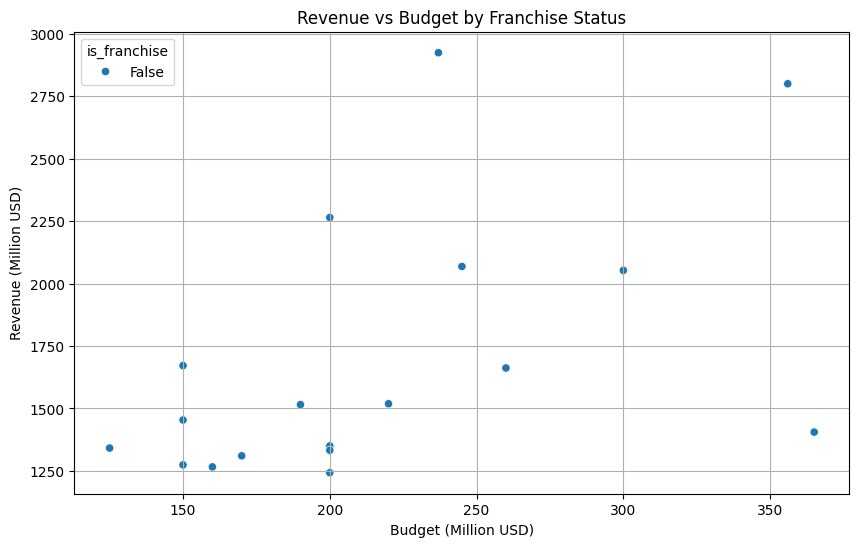

In [32]:
# Revenue vs Budget Scatter Plot

plt.figure(figsize=(10, 6))
sns.scatterplot(data=movies_df, x='budget_musd', y='revenue_musd', hue='is_franchise')
plt.title('Revenue vs Budget by Franchise Status')
plt.xlabel('Budget (Million USD)')
plt.ylabel('Revenue (Million USD)')
plt.grid(True)
plt.show()

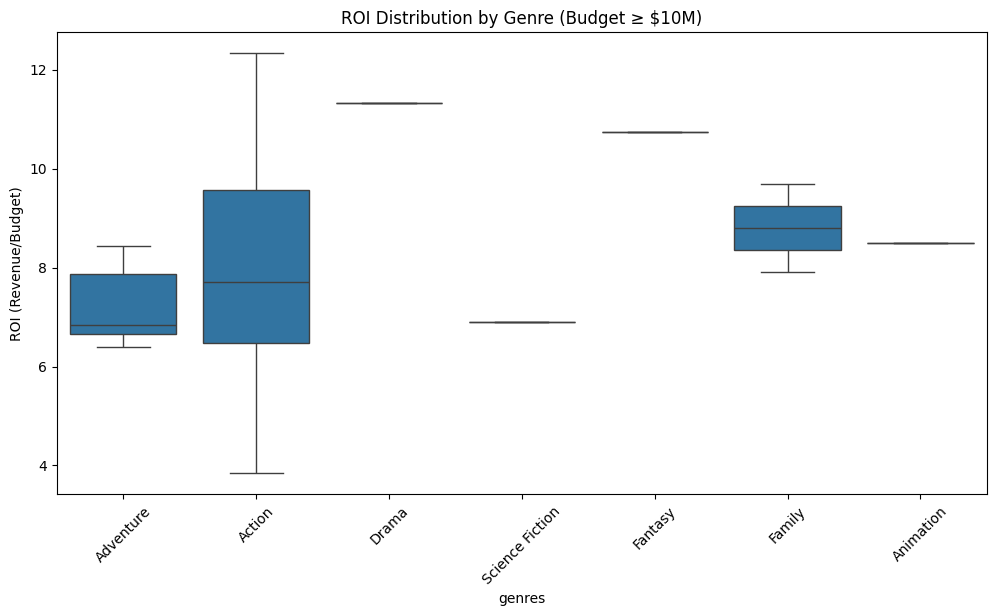

In [33]:
# ROI Distribution by Genre

# Explode genres into separate rows
movies_with_genres = movies_df.assign(genres=movies_df['genres'].str.split('|')).explode('genres')

# Calculate ROI
movies_with_genres['roi'] = movies_with_genres['revenue_musd'] / movies_with_genres['budget_musd']

plt.figure(figsize=(12, 6))
sns.boxplot(data=movies_with_genres[movies_with_genres['budget_musd'] >= 10], 
            x='genres', y='roi')
plt.xticks(rotation=45)
plt.title('ROI Distribution by Genre (Budget ≥ $10M)')
plt.ylabel('ROI (Revenue/Budget)')
plt.show()

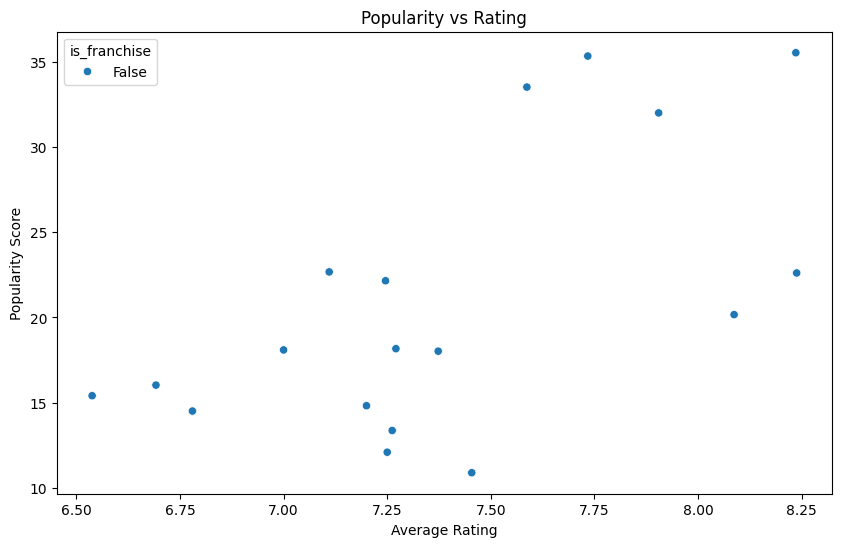

In [34]:
# Popularity vs Rating

plt.figure(figsize=(10, 6))
sns.scatterplot(data=movies_df, x='vote_average', y='popularity', hue='is_franchise')
plt.title('Popularity vs Rating')
plt.xlabel('Average Rating')
plt.ylabel('Popularity Score')
plt.show()

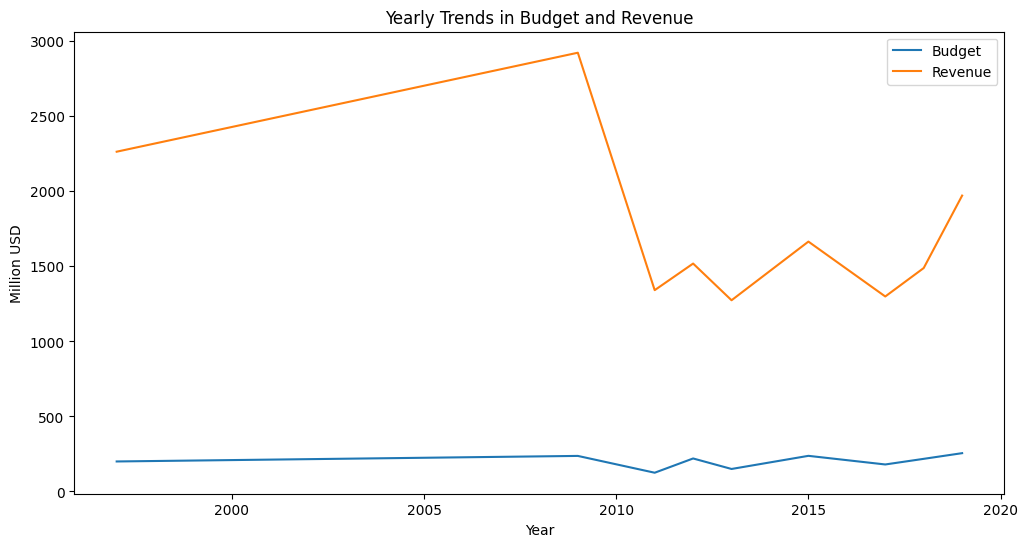

In [35]:
# Yearly Trends

movies_df['release_year'] = movies_df['release_date'].dt.year
yearly_stats = movies_df.groupby('release_year').agg({
    'budget_musd': 'mean',
    'revenue_musd': 'mean',
    'vote_average': 'mean'
}).reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_stats, x='release_year', y='budget_musd', label='Budget')
sns.lineplot(data=yearly_stats, x='release_year', y='revenue_musd', label='Revenue')
plt.title('Yearly Trends in Budget and Revenue')
plt.xlabel('Year')
plt.ylabel('Million USD')
plt.legend()
plt.show()